# Construct the forward variance curve for 15-Feb-2023


### Set up the environment

In [1]:
library(repr)
library(colorspace)
library(stinepack)


### Load relevant R functions

In [2]:
source("fwdVarCurve.R")
source("FukasawaRobust.R")
source("plotIvolsMC.R")


### Load volatility smiles from 15-Feb-2023

In [3]:
load("spxVixVols20230215.rData")

ivolData <- spxIvols20230215

head(ivolData)


,Expiry,Texp,Strike,Bid,Ask,Fwd,CallMid
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20230216,0.002737851,1000,NA,7.793085,4146.742,NA
2,20230216,0.002737851,1200,NA,6.813266,4146.742,NA
3,20230216,0.002737851,1400,NA,5.987566,4146.742,NA
4,20230216,0.002737851,1600,NA,5.273554,4146.742,NA
5,20230216,0.002737851,1800,NA,4.644049,4146.742,NA
6,20230216,0.002737851,2000,NA,4.080578,4146.742,NA


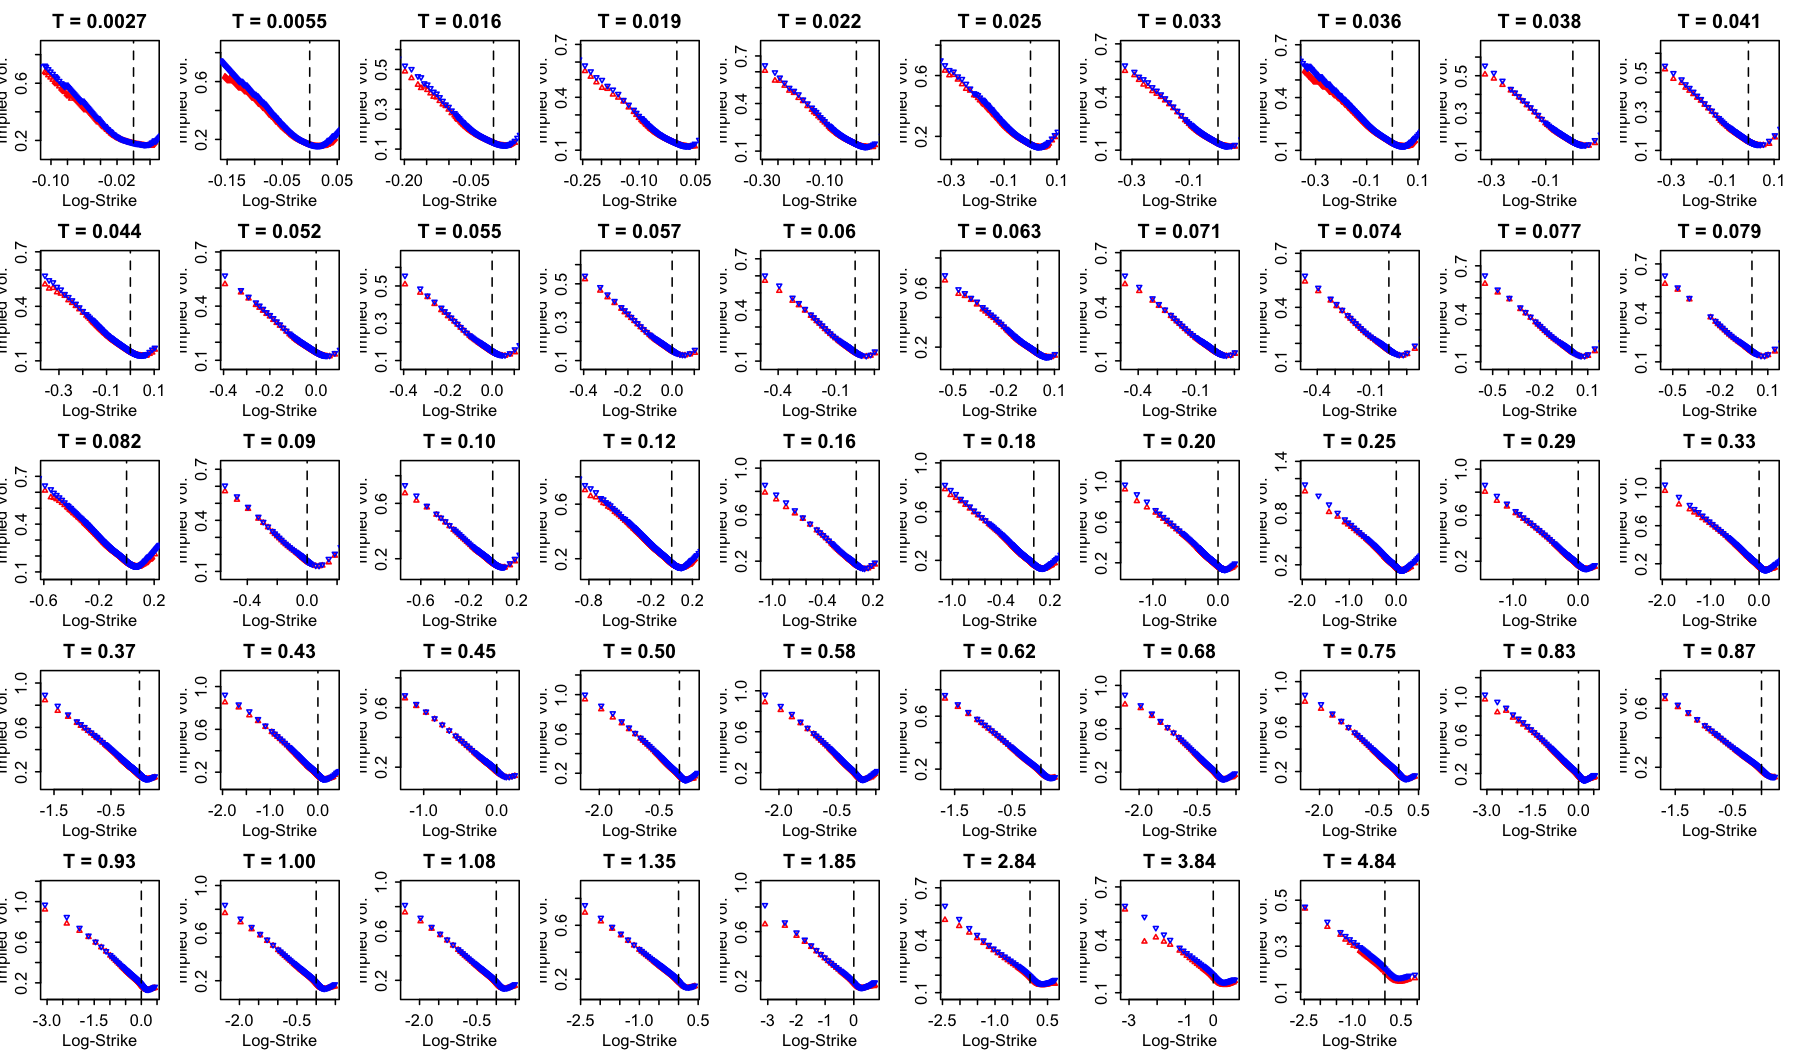

In [4]:
options(repr.plot.width = 12, repr.plot.height = 7, repr.plot.res = 150)

res.plot <- plotIvolsMC(ivolData)


Figure 1: SPX smiles as of February 15, 2023.

### Set up nice colors

In [5]:
bl <- "royalblue"
rd <- "red2"
pk <- "hotpink1"
gr <- "green4"
br <- "brown"
pu <- "purple"
or <- "orange"


### Robust estimation of the variance contract

In [6]:
expiries <- res.plot$expiries

(vs <- varSwap.Robust(ivolData)$vs.mid)


[1] 0.03652933 0.03177763 0.01980144 0.02162058 0.02398171 0.02600709
 [7] 0.02304800 0.02422691 0.02542176 0.02626088 0.02728127 0.02518733
[13] 0.02708168 0.02778900 0.02838281 0.03078455 0.02882814 0.03262349
[19] 0.03303692 0.03330855 0.03330458 0.03215471 0.03728564 0.03685266
[25] 0.03840159 0.03827289 0.03897630 0.04221298 0.04176632 0.04490341
[31] 0.04532925 0.04673886 0.04638431 0.04938991 0.05067169 0.05097511
[37] 0.05258380 0.05366169 0.05525559 0.05284341 0.05447486 0.05445440
[43] 0.05493113 0.05527497 0.05719454 0.05678801 0.05711122 0.05946511

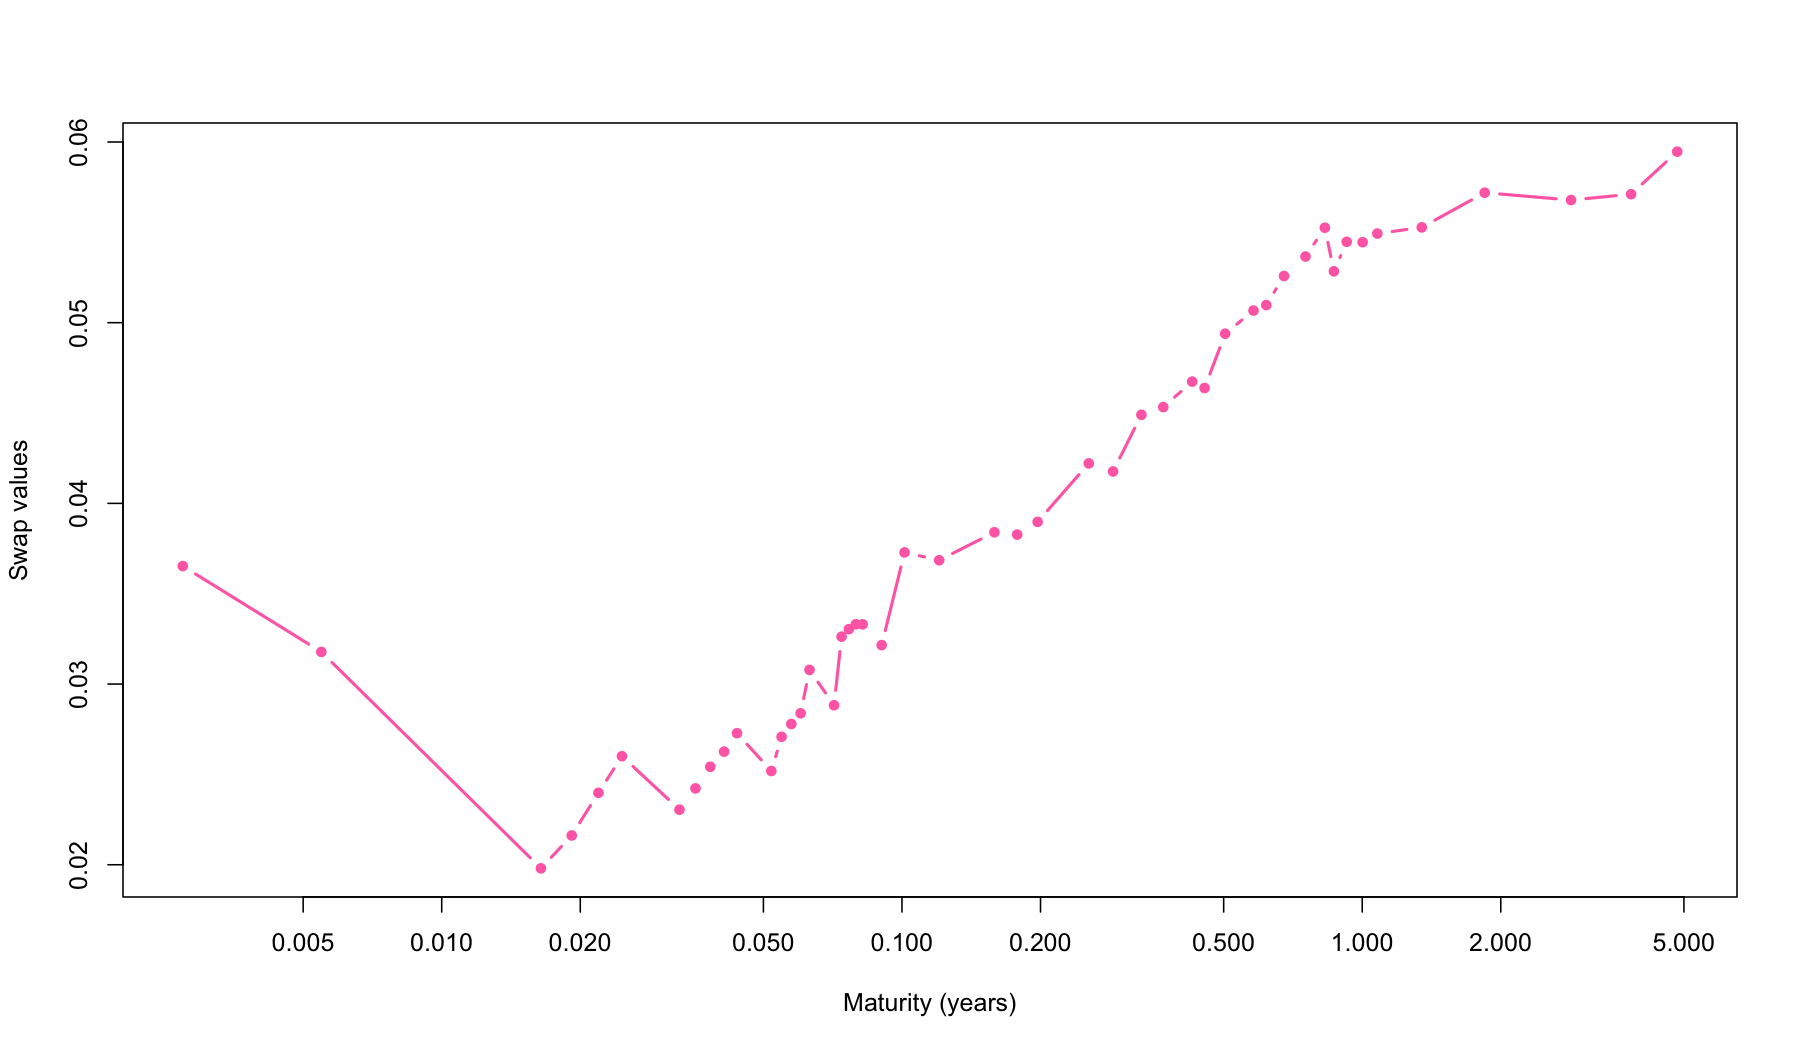

In [7]:
plot(expiries, vs,
  type = "b", pch = 20, lwd = 2, col = pk,
  ylab = "Swap values", xlab = "Maturity (years)", log = "x"
)


Figure 2: Log-linear plot of the forward variance curve.

### The forward variance curve from the variance curve

- By defition, $\xi_t(u) = \mathbb{E}_t[V_u]$.

- The fair value of the variance contract is given by
$$
    M_t(T)=\int_t^T\,\xi_t(u)\,du. 
$$


- Differentiating with respect to $T$ gives
$$
    \xi_t(T)= \partial_T M_t(T).
$$

### Exact smooth forward curve construction

- In 2019, Baruch MFE student Rick Cao implemented (beautifully) a beautiful paper of [Filipović and Willems](https://arxiv.org/abs/1606.03899) 


- That paper presents a non-parametric method to estimate the discount curve from market quotes, that reproduces the market quotes perfectly and has maximal smoothness in the sense that it minimizes the $L^2$-norm of the forward curve.


- We apply this method to the variance swap curve.
    - The resulting forward variance curve is piecewise quadratic.
    
    
- Warning: The resulting forward variance curve is not guaranteed to be positive - though this does not seems to matter in practice.

### Adding a bid-offer spread to smooth the curve

- In practice, `w.in` is not known exactly but only up to some bid-offer spread.
    - Moreover some expirations have more strikes than others and we get a better estimate.



- We input this bid-offer volatility spread using the `eps` parameter.

### Why the forward variance curve should be smooth

- If there are two forward variance curves that are consistent with the data, the smoother one is better.


- To see why, consider trading forward variance swaps around discontinuities in the forward curve!

In [8]:
xi.curve.smooth


function (expiries, w.in, xi = TRUE, eps = 0) 
{
    phi <- function(tau) {
        function(x) {
            min <- pmin(x, tau)
            return(1 - min^3/6 + x * tau * (2 + min)/2)
        }
    }
    phi.deri <- function(tau) {
        function(x) {
            min <- pmin(x, tau)
            return(tau - min^2/2 + tau * min)
        }
    }
    n <- length(expiries)
    c <- diag(n)
    A <- array(dim = c(n, n))
    for (i in seq(1, n)) {
        A[i, ] <- phi(expiries[i])(expiries)
    }
    A.inv <- solve(A)
    obj.1 <- function(err.vec) {
        v <- w.in + 2 * sqrt(w.in) * err.vec * sqrt(expiries)
        return(t(v) %*% A.inv %*% v)
    }
    res.optim <- optim(rep(0, n), obj.1, method = "L-BFGS-B", 
        lower = rep(-eps, n), upper = rep(eps, n))
    err.vec <- res.optim$par
    w.in.1 <- w.in + 2 * sqrt(w.in) * err.vec * sqrt(expiries)
    Z <- A.inv %*% w.in.1
    curve.raw <- function(x) {
        sum.curve <- 0
        sum.curve.deri <- 0
        for (i in seq(1, n)) {
            sum.curve <- sum.curve + Z[i] * phi(expiries[i])(x)
            sum.curve.deri <- sum.curve.deri + Z[i] * phi.deri(expiries[i])(x)
        }
        if (xi) {
            return(sum.curve.deri)
        }
        else {
            return(sum.curve)
        }
    }
    xi.curve.out <- Vectorize(curve.raw)
    fit.errs <- sqrt(w.in.1/expiries) - sqrt(w.in/expiries)
    return(list(xi.curve = xi.curve.out, fit.errs = fit.errs, 
        w.out = w.in.1))
}

In [9]:
w.in <- vs * expiries
xi.smooth <- xi.curve.smooth(expiries, w.in, eps = .03)
xi.smooth.c <- xi.smooth$xi.curve
xi.smooth.w.out <- xi.smooth$w.out


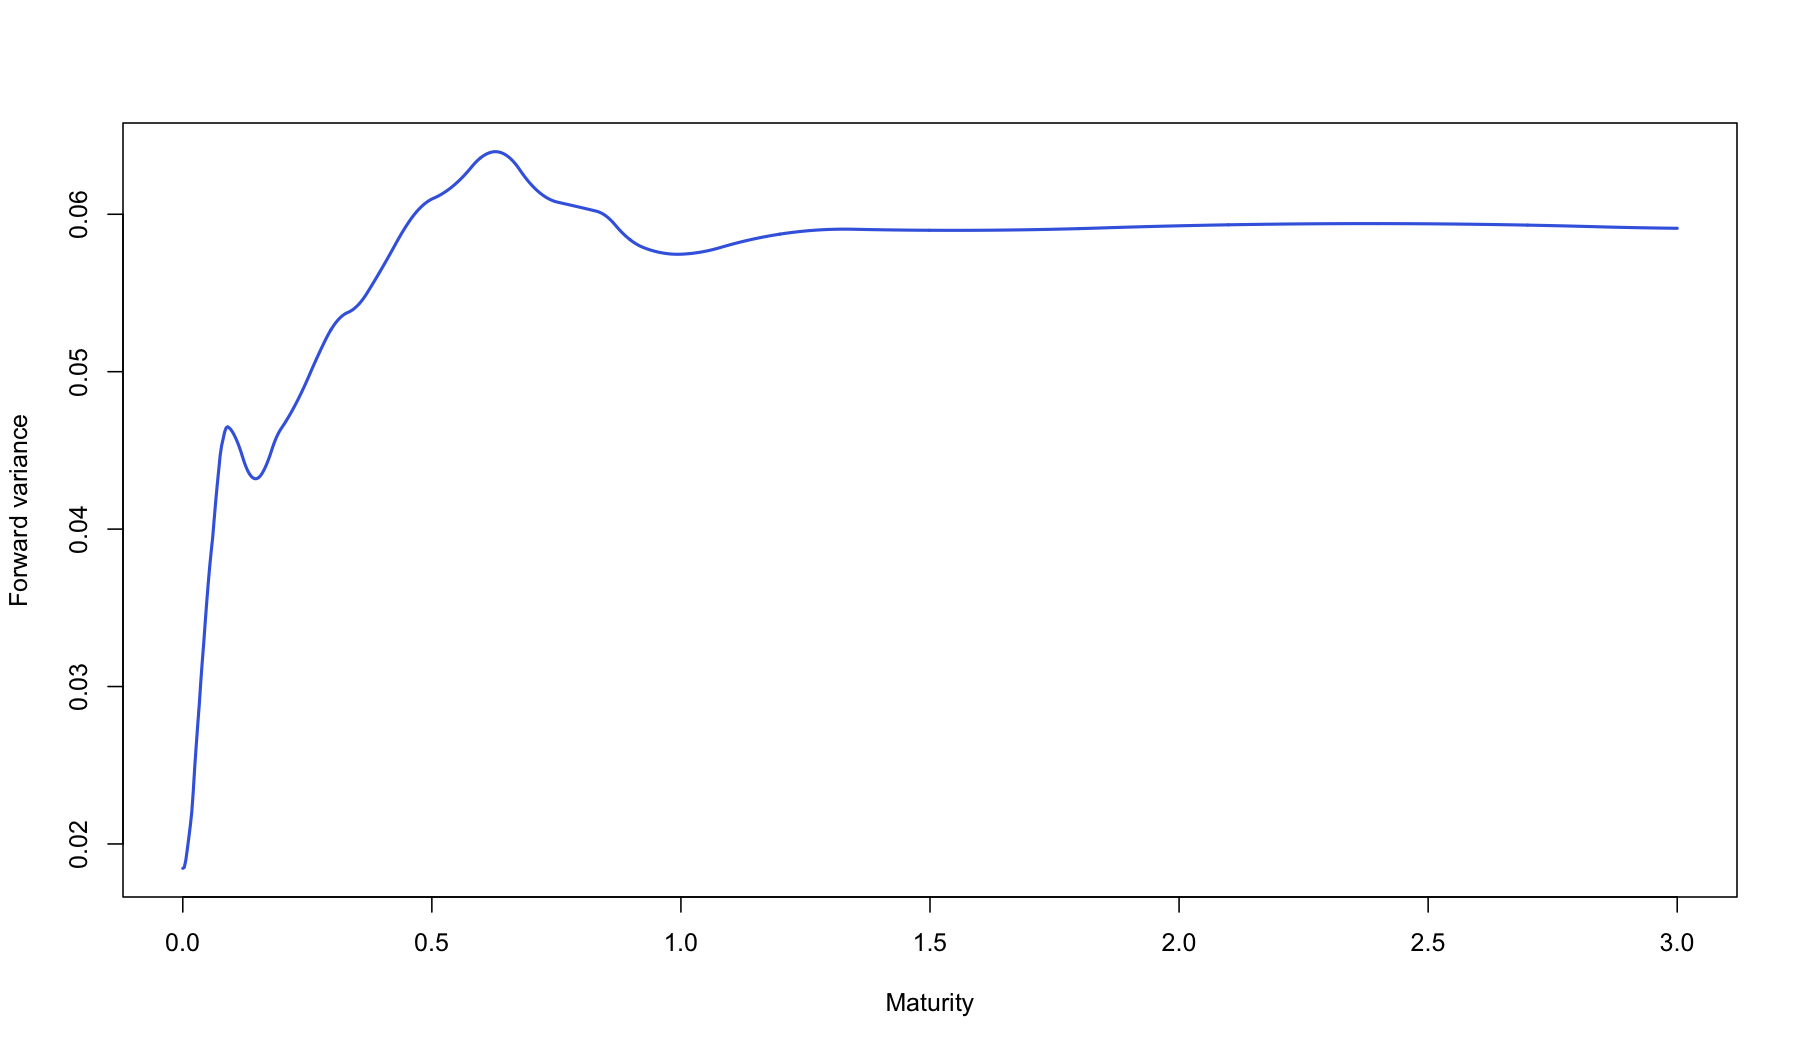

In [11]:
curve(xi.smooth.c,
  from = 0, to = 3, col = bl, lty = 1, lwd = 2,
  xlab = "Maturity", ylab = "Forward variance", n = 1000
)


Figure 3: Smooth approximation to the forward variance curve.  We have used a large bid//offer spread to get a smoother curve. 

### What does exact interpolation mean?

- Output variance swaps exactly match input variance swaps (up to the bid-offer spread).

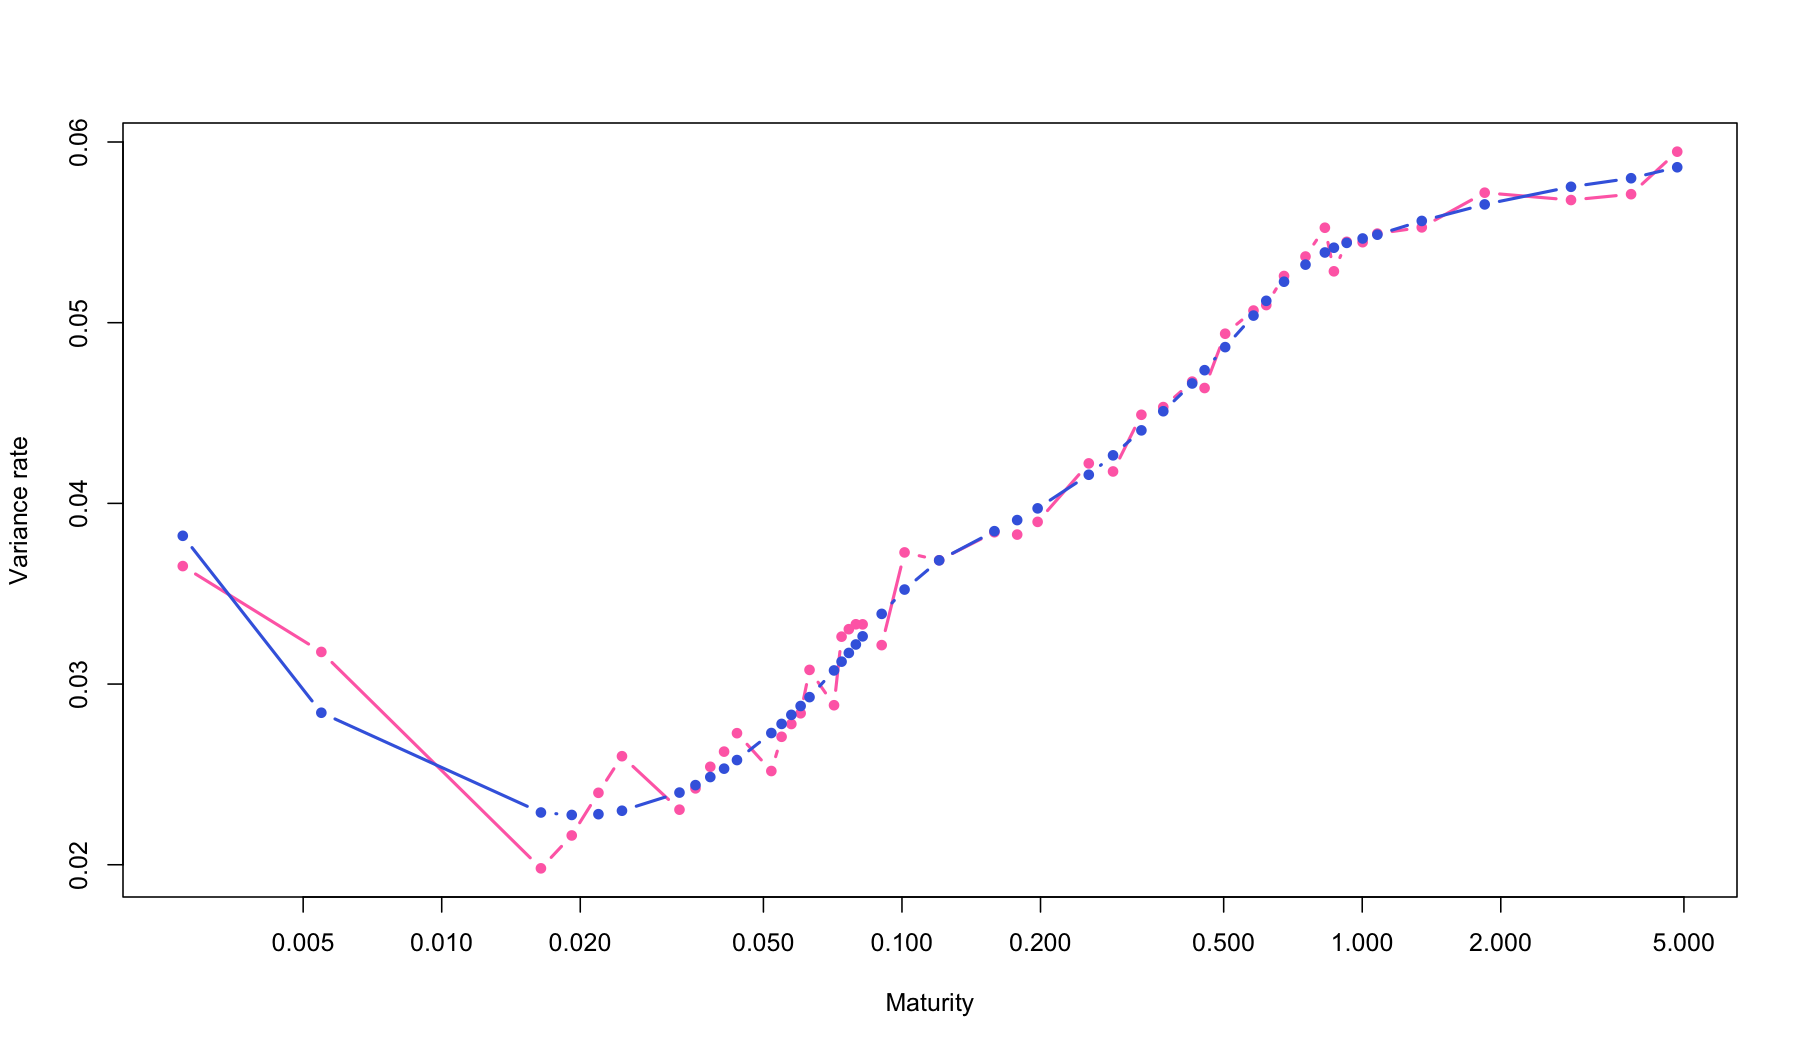

In [12]:
plot(expiries, w.in / expiries,
  col = pk, lwd = 2, pch = 20, xlab = "Maturity",
  ylab = "Variance rate", type = "b", log = "x"
)
points(expiries, xi.smooth.w.out / expiries,
  col = bl, pch = 20,
  lwd = 2, type = "b"
)


Figure 4: Pink circles are input variance contracts; blue circles are output variance swaps variance contracts.

### Instantiate the forward variance curve

We can speed things up by instantiating the curve:

In [13]:
xiCurveObj <- CurveSmoothBuilder(expiries, vs * expiries, eps = .03)
xiCurveObj$fitCurve()
xi.curve.fast <- xiCurveObj$getForwardVarCurve()


Note: Object-oriented programming in R.  We can even save the object for future use!

In [14]:
save_option <- FALSE # set to TRUE to save the object

if (save_option) {
  save(xiCurveObj, file = "xi20230215.rData")
}


### Plot the fast instantiated forward variance curve

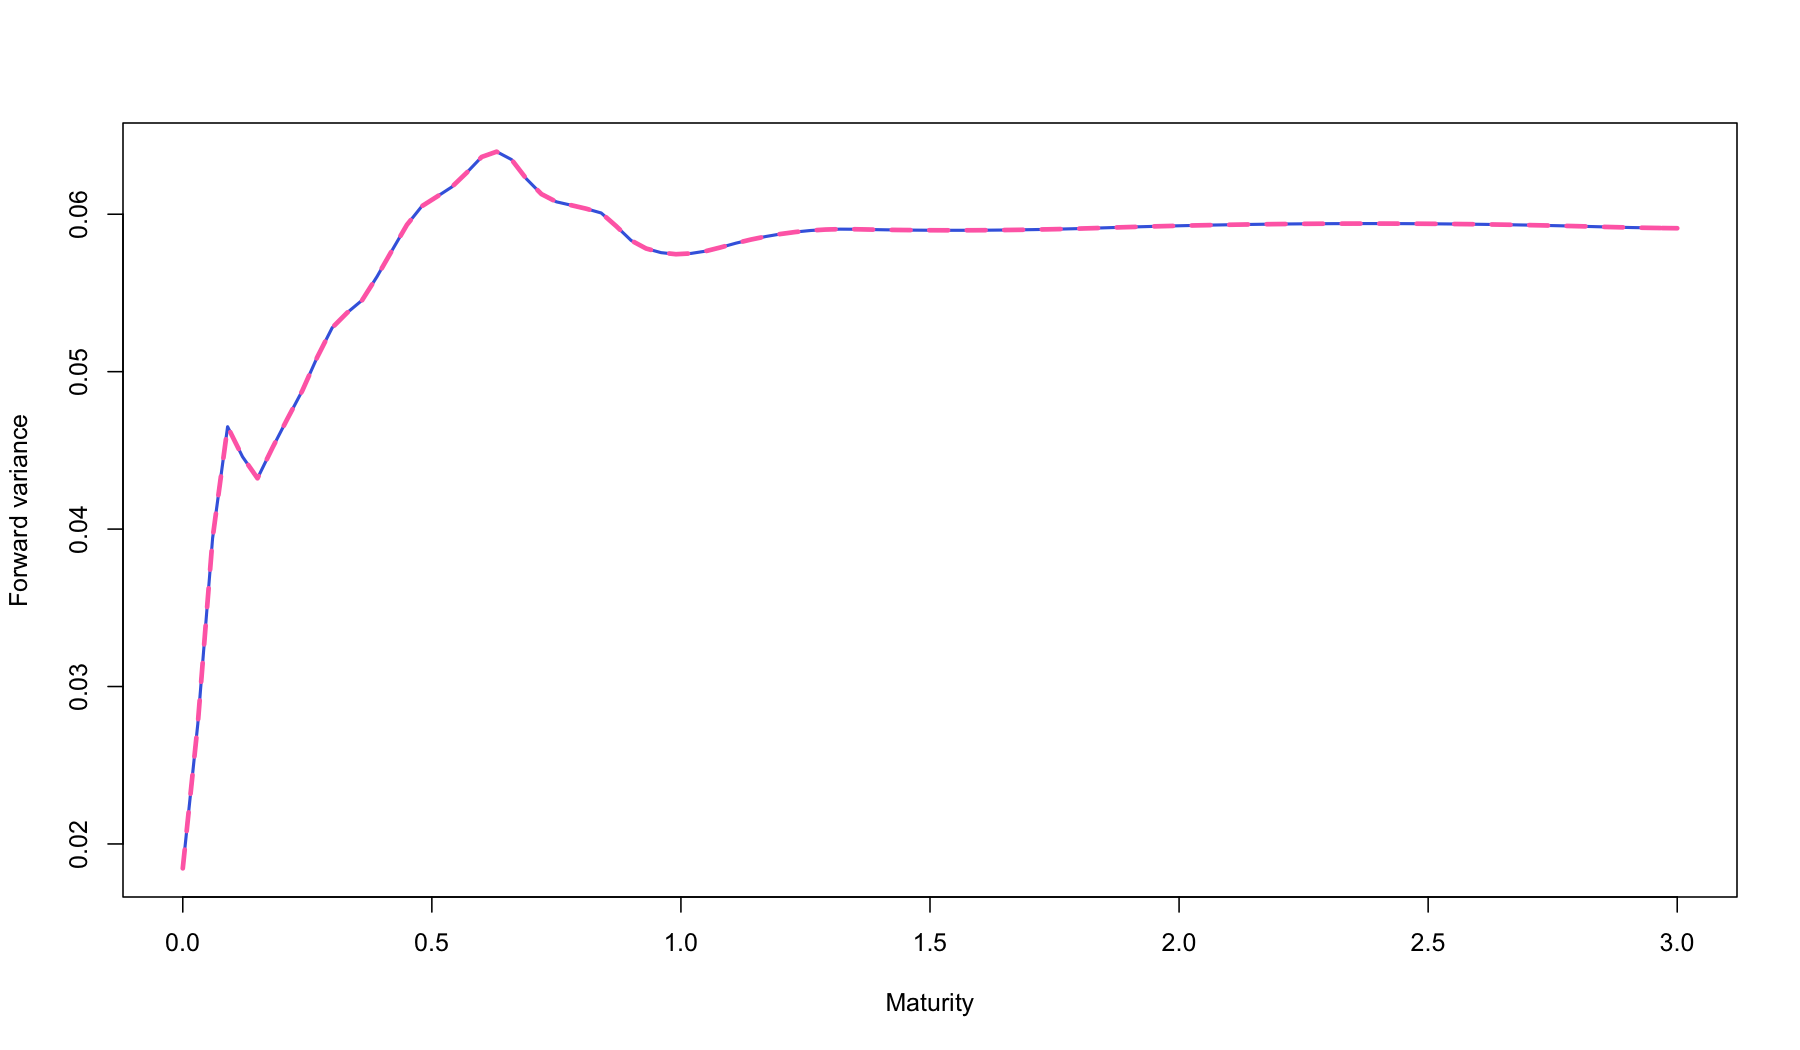

In [15]:
curve(xi.smooth.c,
  from = 0, to = 3, col = bl, lty = 1, lwd = 2,
  xlab = "Maturity", ylab = "Forward variance"
)
curve(xi.curve.fast,
  from = 0, to = 3, col = pk,
  lwd = 3, add = TRUE, lty = 2
)


Figure 5: Original and fast (instantiated) forward variance curve.